In [2]:
# !pip install -qq pycocotools
# !pip install -qq opencv-python
# !pip install -qq Pillow
# !pip install -qq numpy
# !pip install -qq matplotlib
# !pip install -qq scikit-image
# !pip install -qq moviepy
# !pip install -qq tqdm

In [1]:
import os
from pathlib import Path
import json
import re
import shutil
from typing import List, Tuple, Union

import cv2
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from numpy.typing import NDArray

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

from skimage import io

# from moviepy.editor import VideoFileClip

from tqdm import tqdm

%matplotlib inline

For now, there is only one patient
```
> Patient1_RLL_IPV_AnnotationComplete/RLL_InferiorPulmonaryVein_Frames_40-390
    > data
        > index.json
        > inferior-pulmonary-vein-ms-RLL-1k+.mp4
        > manifest.json
    > annotations.json
    > task.json
> Patient1_RLL_IPV_AnnotationComplete/RLL_InferiorPulmonaryVein_Frames_291-740
    > ...
> Patient1_RLL_IPV_AnnotationComplete/RLL_InferiorPulmonaryVein_Frames_741-1090
    > ...
```

Copy the video from `../Patient1_RLL_IPV_AnnotationComplete/RLL_InferiorPulmonaryVein_Frames_40-390/data/inferior-pulmonary-vein-ms-RLL-1k+.mp4` to `../`

Create folder frames  
Convert the video to frames, in original FPS at higest quality inside frames folder

In [4]:
# !cd Patient1_RLL_IPV_AnnotationComplete
# !mkdir ../frames
# !ffmpeg -i inferior-pulmonary-vein-ms-RLL-1k+.mp4 -q:v 0 -compression_level 0 -start_number 0 ../frames/frame_%06d.png

In [2]:
# function to search all the json files in the directory and subdirectories
def search_json_files(directory: str):
    """
    Get all the JSON files present in the folder by looking into the `directory` and
    all the sub-folders recusively.

    NOTE: Should only have JSONs which are required, if there are extra JSONs it considers those too.
    """
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Taking json files from folders of "AnnotationComplete"
            if (file.endswith(".json")) and ("AnnotationComplete" in root) and "annotation" in file:
                json_files.append(Path(os.path.join(root, file)))
    return json_files

json_paths = search_json_files('../Patient1_RLL_IPV_AnnotationComplete')
json_paths


[PosixPath('../Patient1_RLL_IPV_AnnotationComplete/RLL_inferiorpulmonaryvein_frames_391-740/annotations.json'),
 PosixPath('../Patient1_RLL_IPV_AnnotationComplete/RLL_inferiorpulmonaryvein_frames_741-1090/annotations.json'),
 PosixPath('../Patient1_RLL_IPV_AnnotationComplete/RLL_InferiorPulmonaryVein_Frames_40-390/annotations.json')]

In [3]:
def extract_frame_numbers(path):
    path = Path(path).parent.name
    pattern = r"\d+-\d+"
    matches = re.findall(pattern, path)

    return [tuple(map(int, match.split('-'))) for match in matches]

In [4]:
# test
for path in json_paths:
    print(extract_frame_numbers(path))

[(391, 740)]
[(741, 1090)]
[(40, 390)]


In [63]:
# create a Path object for each json file
json_paths = [Path(path) for path in json_paths]
# Path of data in grandparent of each json file
data_paths = [path.parent.parent / 'data' for path in json_paths]

In [64]:
data_paths

[PosixPath('../Patient1_RLL_IPV_AnnotationComplete/data'),
 PosixPath('../Patient1_RLL_IPV_AnnotationComplete/data'),
 PosixPath('../Patient1_RLL_IPV_AnnotationComplete/data')]

In [5]:
def get_cropping_co_ord(image: NDArray):
    """
    Crop the Image
    Loop through each direction, left, right, top and bottom

    When ever the pixel value is greater than [5,5,5], use that pixel as starting
    point for the crop in that direction.
    """
    h, w, _ = image.shape
    # Getting TOPL_X
    for i in range(w):
        if not np.any(image[h//2,i,:] < (5,5,5)):
            TOPL_X = i
            break
        
    # Getting TOPL_Y
    for i in range(h):
        if not np.any(image[i,w//2,:] < (5,5,5)):
            TOPL_Y = i
            break
    
    # Getting BOTTOMR_X
    for i in range(w-1,0,-1):
        if not np.any(image[h//2,i,:] < (5,5,5)):
            BOTTOMR_X = i
            break
    
    # Getting BOTTOMR_Y
    for i in range(h-1,0,-1):
        if not np.any(image[i,w//2,:] < (5,5,5)):
            BOTTOMR_Y = i
            break

    return TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y

190 1 1084 716


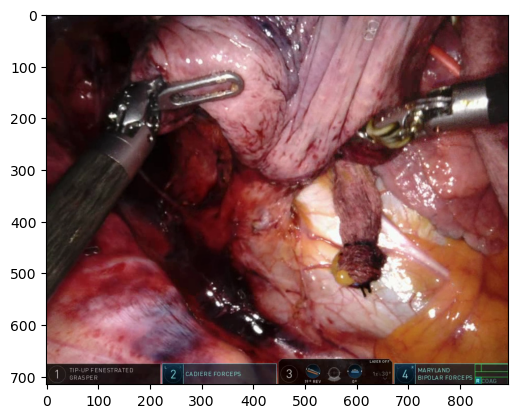

In [6]:
# Get cropping co-ordinates for one image
img = io.imread("../Patient1_RLL_IPV_AnnotationComplete/frames/frame_000100.png")
x1,y1,x2,y2 = get_cropping_co_ord(img)
print(x1,y1,x2,y2)
plt.imshow(img[y1:y2,x1:x2])

(720, 900, 3)


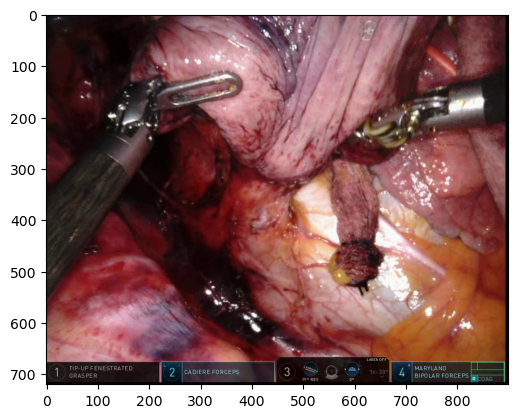

In [7]:
TOPL_X, TOPL_Y, BOTTOMR_X, BOTTOMR_Y = 190, 0, 1090, 720
print(img[TOPL_Y:BOTTOMR_Y,TOPL_X:BOTTOMR_X].shape)
plt.imshow(img[TOPL_Y:BOTTOMR_Y,TOPL_X:BOTTOMR_X])

In [8]:
# Read the json file and return the data

for json_path in json_paths:
    # json_path.parent.name -> RLL_inferiorpulmonaryvein_frames_391-740
    start, end = json_path.parent.name.split("_")[-1].split("-") # 391, 740

    patient_full = json_path.parent.parent.name # Patient1_RLL_IPV_AnnotationComplete
    patient_name = patient_full.split("_")[0] # Patient1
    # Extract number from Patient1 using regex
    patient_num = "p" + re.findall(r"\d+", patient_name)[0] # p1
    patient = patient_num+"_"+start+"_"+end
    print("Starting for folder:", patient)
    # Create a folder for each patient
    os.makedirs(f"../frames/{patient}", exist_ok=True)
    os.makedirs(f"../masks/{patient}", exist_ok=True)

    json_data = json.load(open(json_path))[0]

    idx = 0
    for shape in tqdm(json_data['shapes']):
        frame_name = "frame_" + f"{shape['frame']:06d}"
        
        polygon = shape['points']
        polygon = np.array(polygon).reshape((-1, 2)).astype(np.int32)
        # Adjust polygon coordinates based on the crop
        polygon[:, 0] -= TOPL_X
        polygon[:, 1] -= TOPL_Y
        
        img = io.imread(f"../{patient_full}/frames/{frame_name}.png")[TOPL_Y:BOTTOMR_Y,TOPL_X:BOTTOMR_X]
        # Save image to the patient frames folder
        io.imsave(f"../frames/{patient}/{frame_name}.png", img)

        # Convert polygon points to Mask
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        mask = cv2.fillPoly(mask, [polygon], 1)
        # Save mask to the patient masks folder
        io.imsave(f"../masks/{patient}/{frame_name}.png", mask, check_contrast=False)


Starting for folder: p1_391_740


100%|██████████| 343/343 [01:47<00:00,  3.20it/s]


Starting for folder: p1_741_1090


100%|██████████| 352/352 [01:44<00:00,  3.38it/s]


Starting for folder: p1_40_390


100%|██████████| 351/351 [01:48<00:00,  3.24it/s]


### Test

(720, 900, 3)


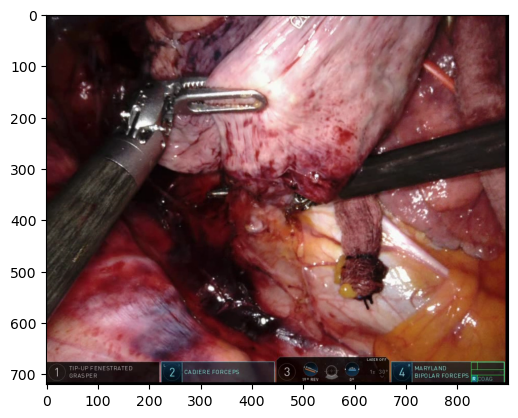

(720, 900, 3)


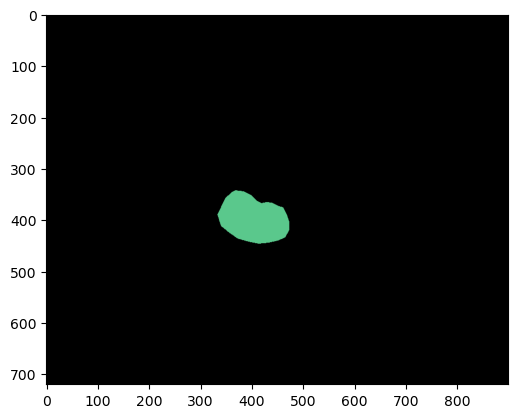

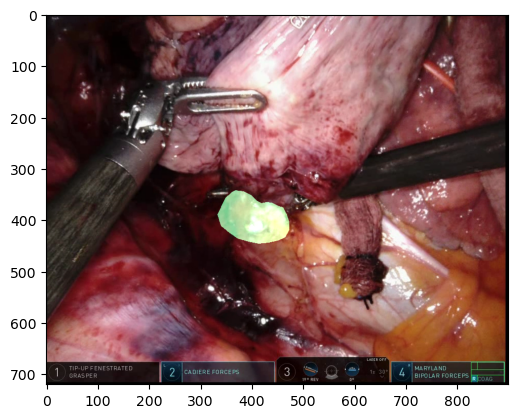

In [9]:
frame = io.imread("../frames/p1_391_740/frame_000400.png")
mask = io.imread("../masks/p1_391_740/frame_000400.png")
print(frame.shape)
plt.imshow(frame); plt.show()
mask = np.tile(mask[..., np.newaxis], (1,1,3))
mask = np.where(mask != 0, (90,200,140), 0).astype(np.uint8)
print(mask.shape)
plt.imshow(mask); plt.show()
# Overlayed image
plt.imshow(cv2.addWeighted(frame, 1, mask, 1, 0)); plt.show()